## Setup

In [1]:
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%config InlineBackend.figure_format = 'retina'

In [2]:
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [ ]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

df = pd.read_csv(DATA_PATH + "mlbootcamp5_train.csv", sep=";")
print("Dataset size: ", df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Convert the data into long format

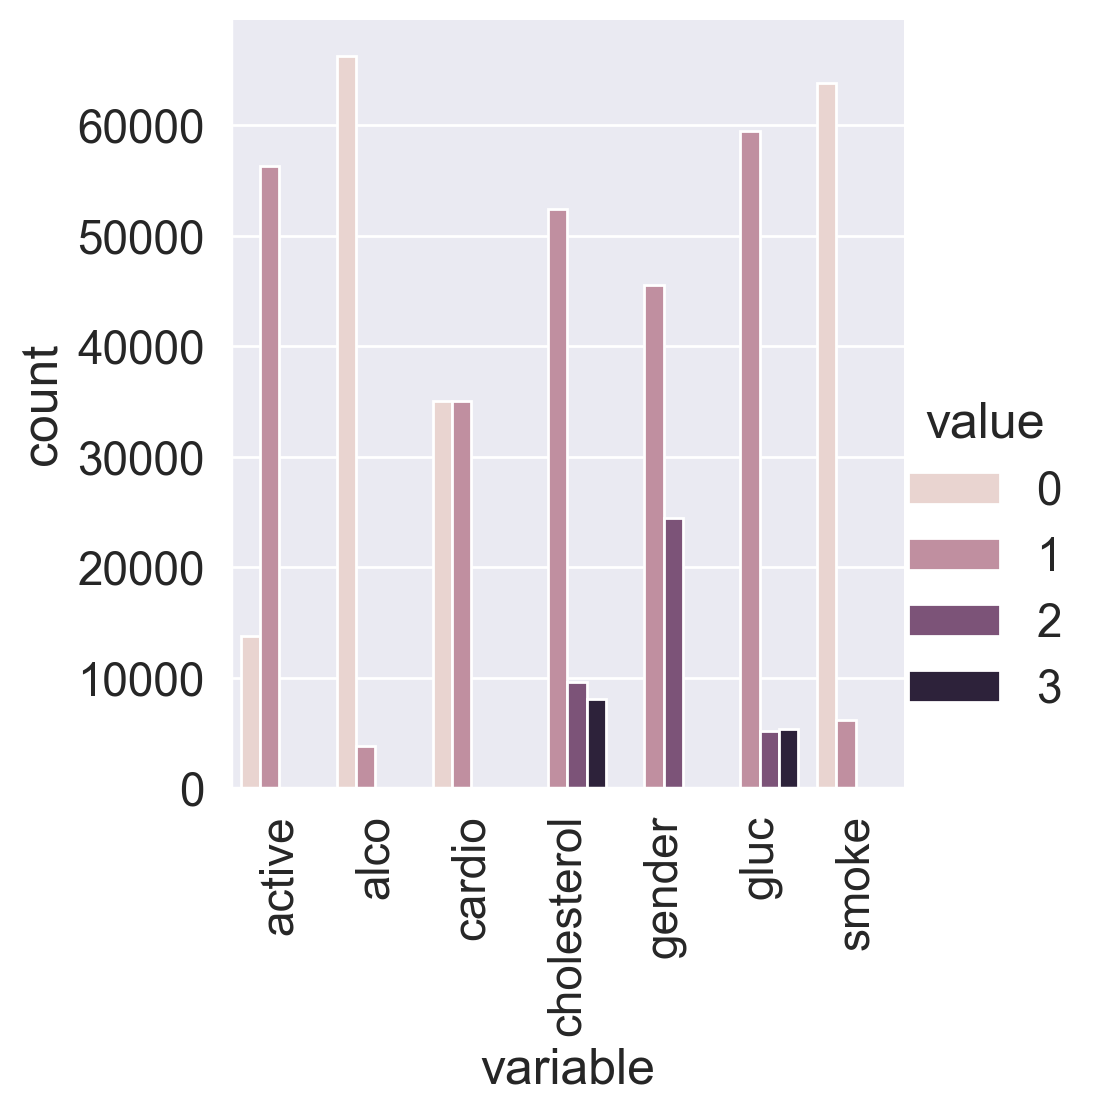

In [4]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar"
)
plt.xticks(rotation='vertical');

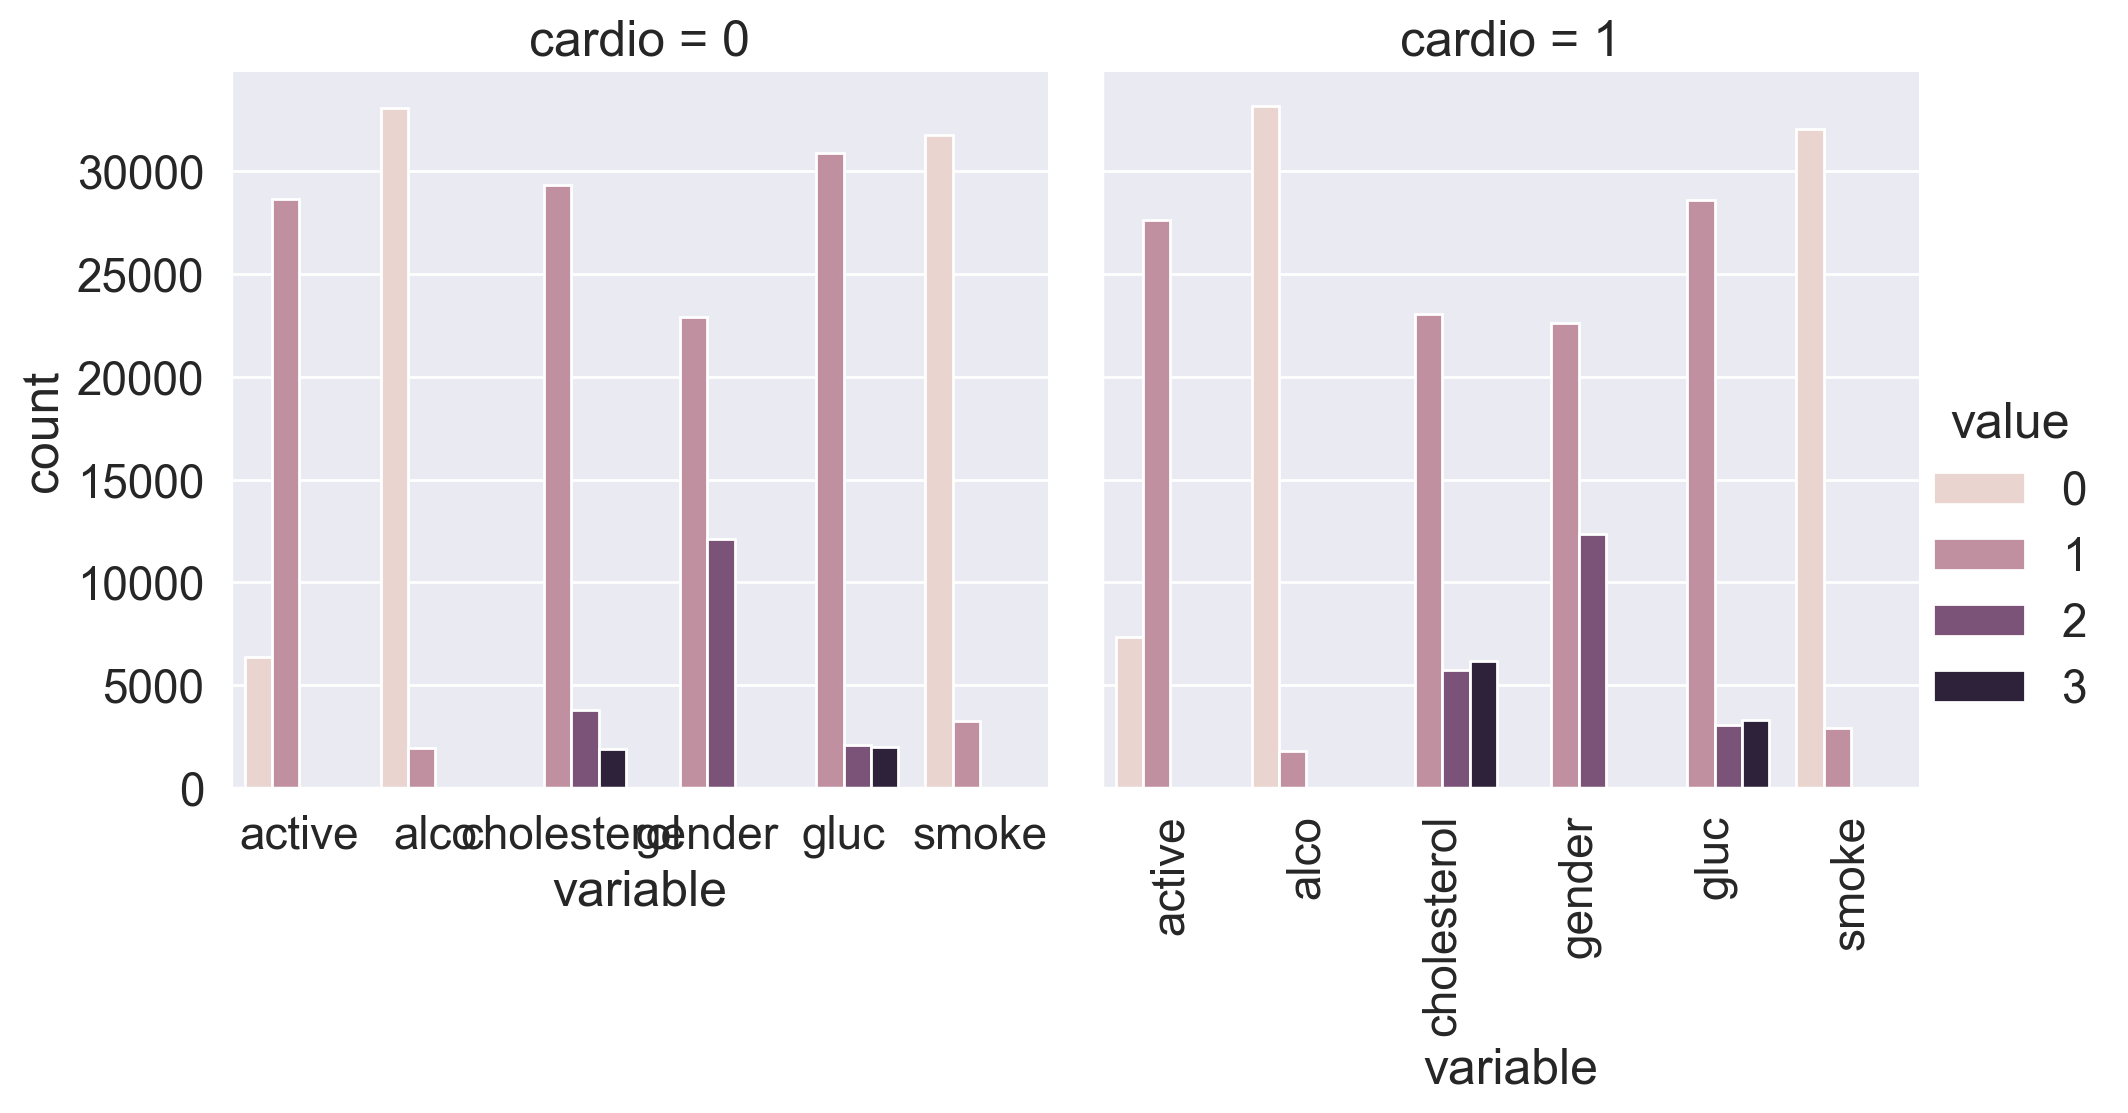

In [5]:
# split the dataset by target values

df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar"
)
plt.xticks(rotation='vertical');

In [ ]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


- 5 numerical features (excluding id);
- 7 categorical features;
- 70000 records in total.

1. How many men and women are present in this dataset? Values of the gender feature were not given (whether “1” stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.

In [8]:
df.groupby("gender")["height"].mean()

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

- 161 cm and almost 170 cm on average, so we make a conclusion that 
- gender=1 represents females, 
- and gender=2 – males. 
- So the sample contains 45530 women and 24470 men.

2. Who more often report consuming alcohol – men or women?

In [9]:
df.groupby("gender")["alco"].mean()

gender
1    0.025500
2    0.106375
Name: alco, dtype: float64

3. What’s the rounded difference between the percentages of smokers among men and women?

In [10]:
df.groupby("gender")["smoke"].mean()

gender
1    0.017856
2    0.218880
Name: smoke, dtype: float64

4. What’s the rounded difference between median values of age (in months) for non-smokers and smokers? You’ll need to figure out the units of feature age in this dataset.

In [11]:
df.groupby("smoke")["age"].median() / 365.25

smoke
0    53.995893
1    52.361396
Name: age, dtype: float64

- Median age of smokers is 52.4 years, for non-smokers it’s 54. We see that the correct answer is 20 months. But here is a way to calculate it exactly:

In [13]:
float(df[df["smoke"] == 0]["age"].median() - df[df["smoke"] == 1]["age"].median()) / 365.25 * 12

19.613963039014372

5. Calculate fractions of ill people (with CVD) in the two groups of people described in the task. What’s the ratio of these two fractions?

In [14]:
df["age_years"] = (df["age"] / 365.25).round().astype("int")
df["age_years"].max()


np.int64(65)

In [15]:
smoking_old_men = df[
    (df["gender"] == 2)
    & (df["age_years"] >= 60)
    & (df["age_years"] < 65)
    & (df["smoke"] == 1)
]

In [16]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 1) & (smoking_old_men["ap_hi"] < 120)
]["cardio"].mean()

np.float64(0.2631578947368421)

In [17]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 3)
    & (smoking_old_men["ap_hi"] >= 160)
    & (smoking_old_men["ap_hi"] < 180)
]["cardio"].mean()

np.float64(0.8636363636363636)

- Difference is approximately 3-fold not 5-fold, as the SCORE scale suggests, but it's possible that the SCORE risk of CVD is nonlinearly related to the proportion of ill people in the given age group.

## Correlation Matrix Visualization

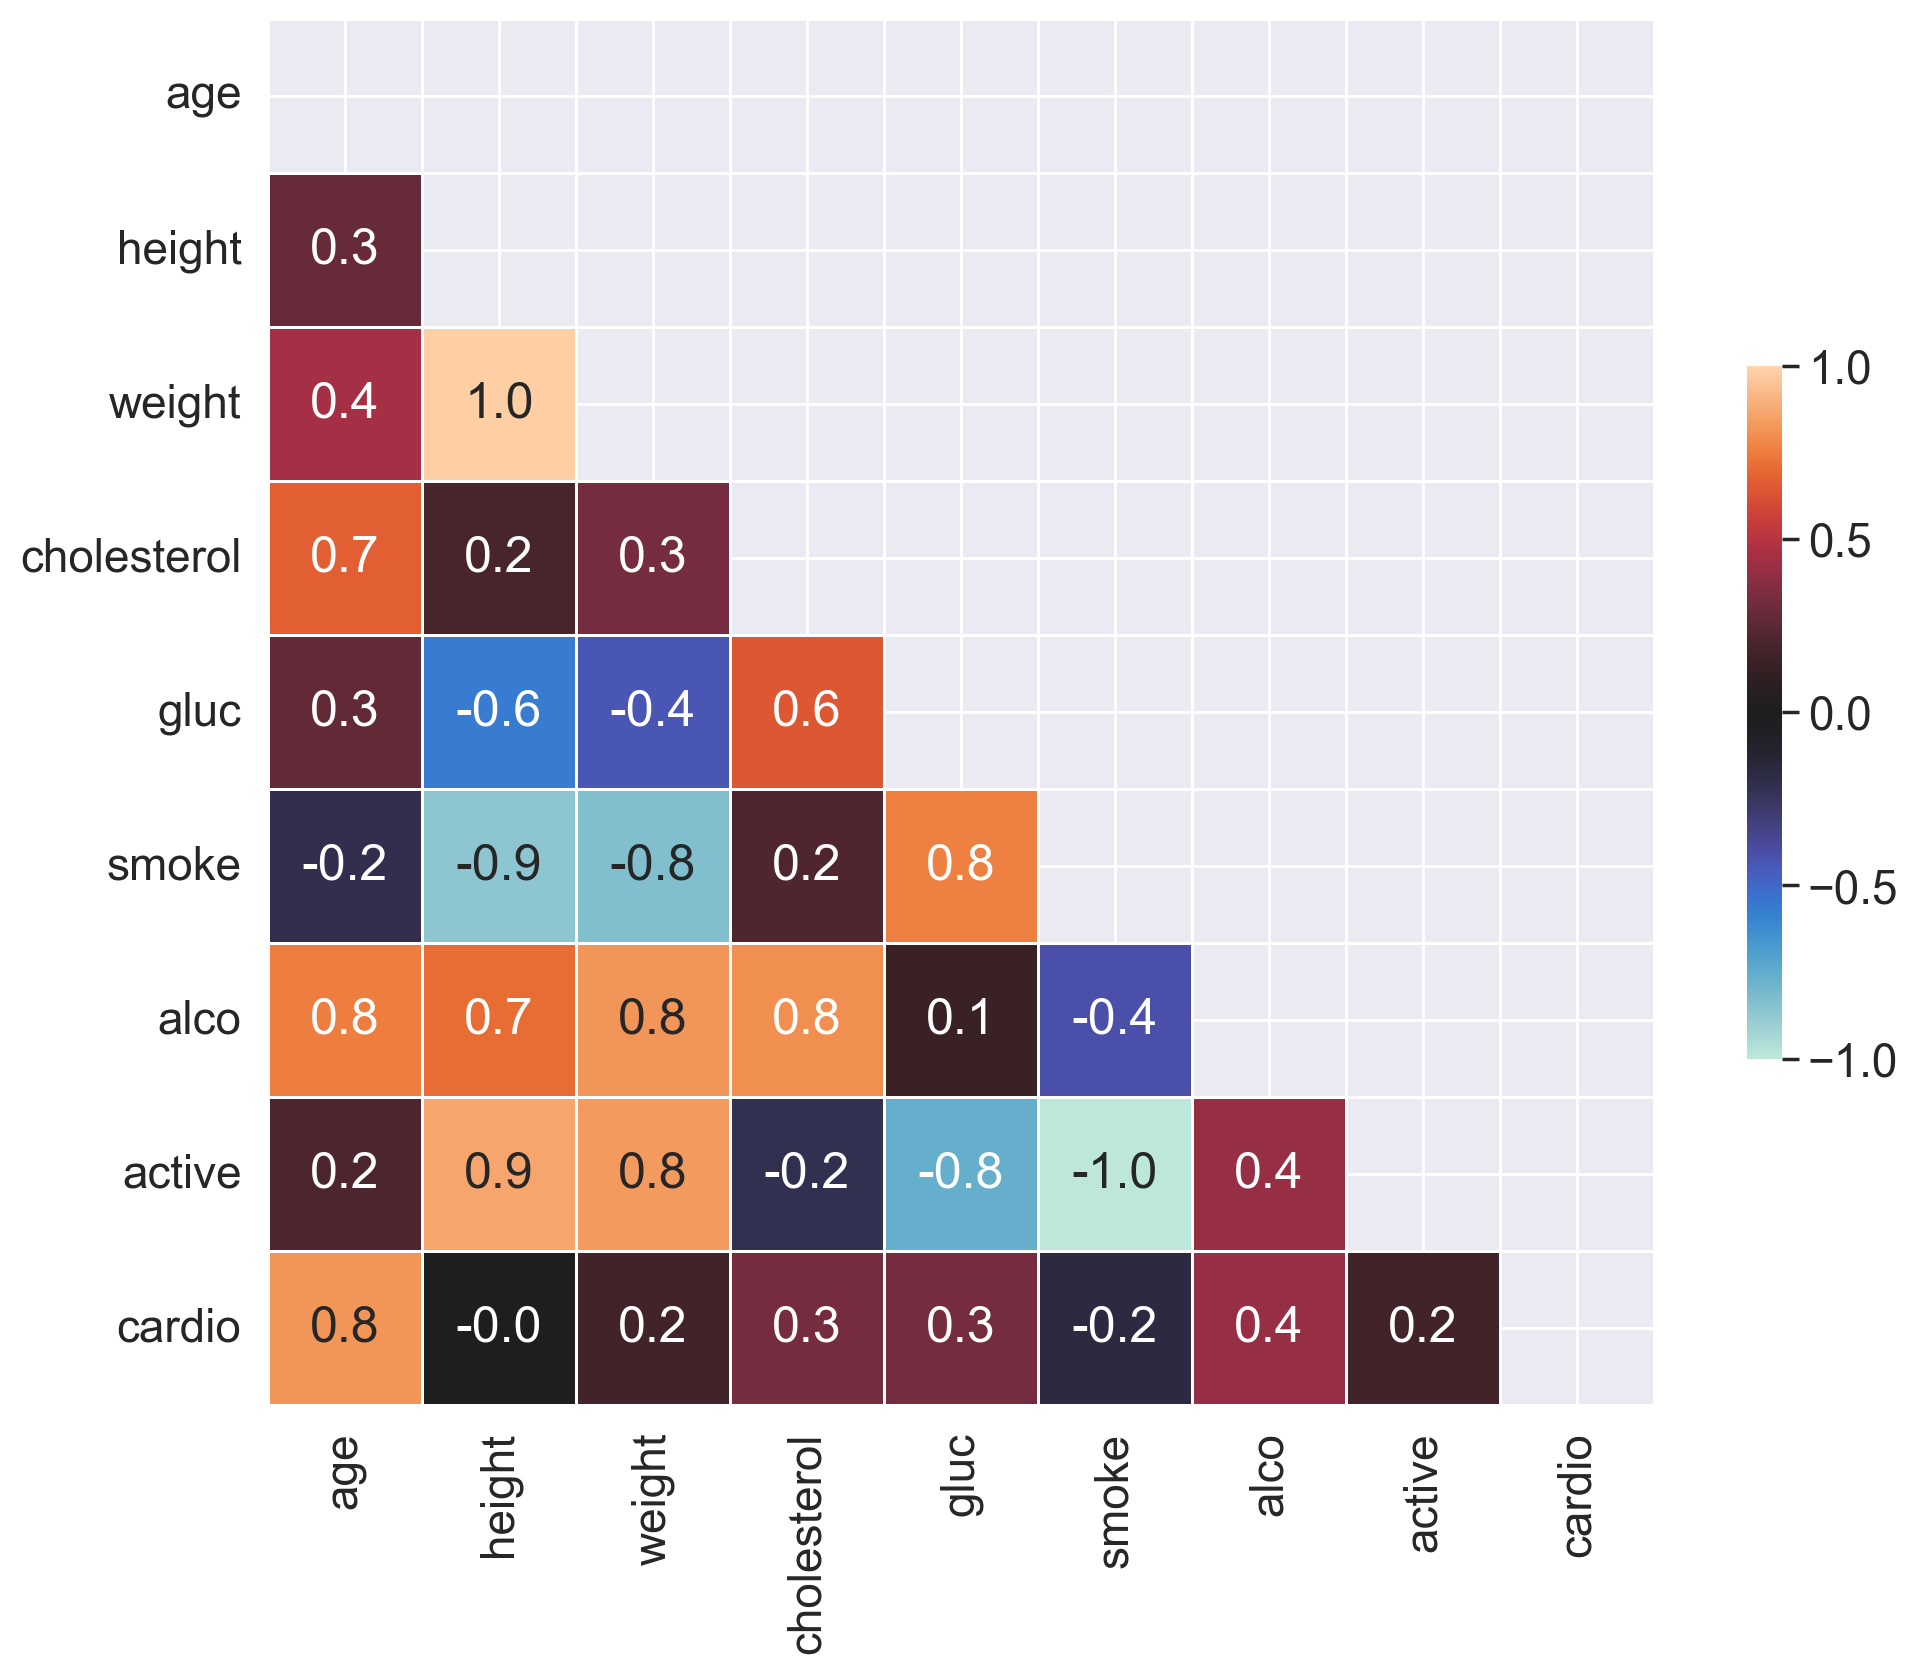

In [24]:
df = pd.DataFrame({  # Replace this with your actual DataFrame
    "age": [50, 40, 60, 30, 45],
    "height": [170, 165, 180, 175, 160],
    "weight": [70, 60, 90, 75, 55],
    "cholesterol": [1, 2, 3, 1, 2],
    "gluc": [1, 2, 2, 1, 3],
    "smoke": [0, 1, 0, 0, 1],
    "alco": [0, 0, 1, 0, 0],
    "active": [1, 0, 1, 1, 0],
    "cardio": [1, 0, 1, 0, 1]
})
corr = df.corr(method="pearson")

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(
    corr,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".1f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

6. Height distribution of men and women

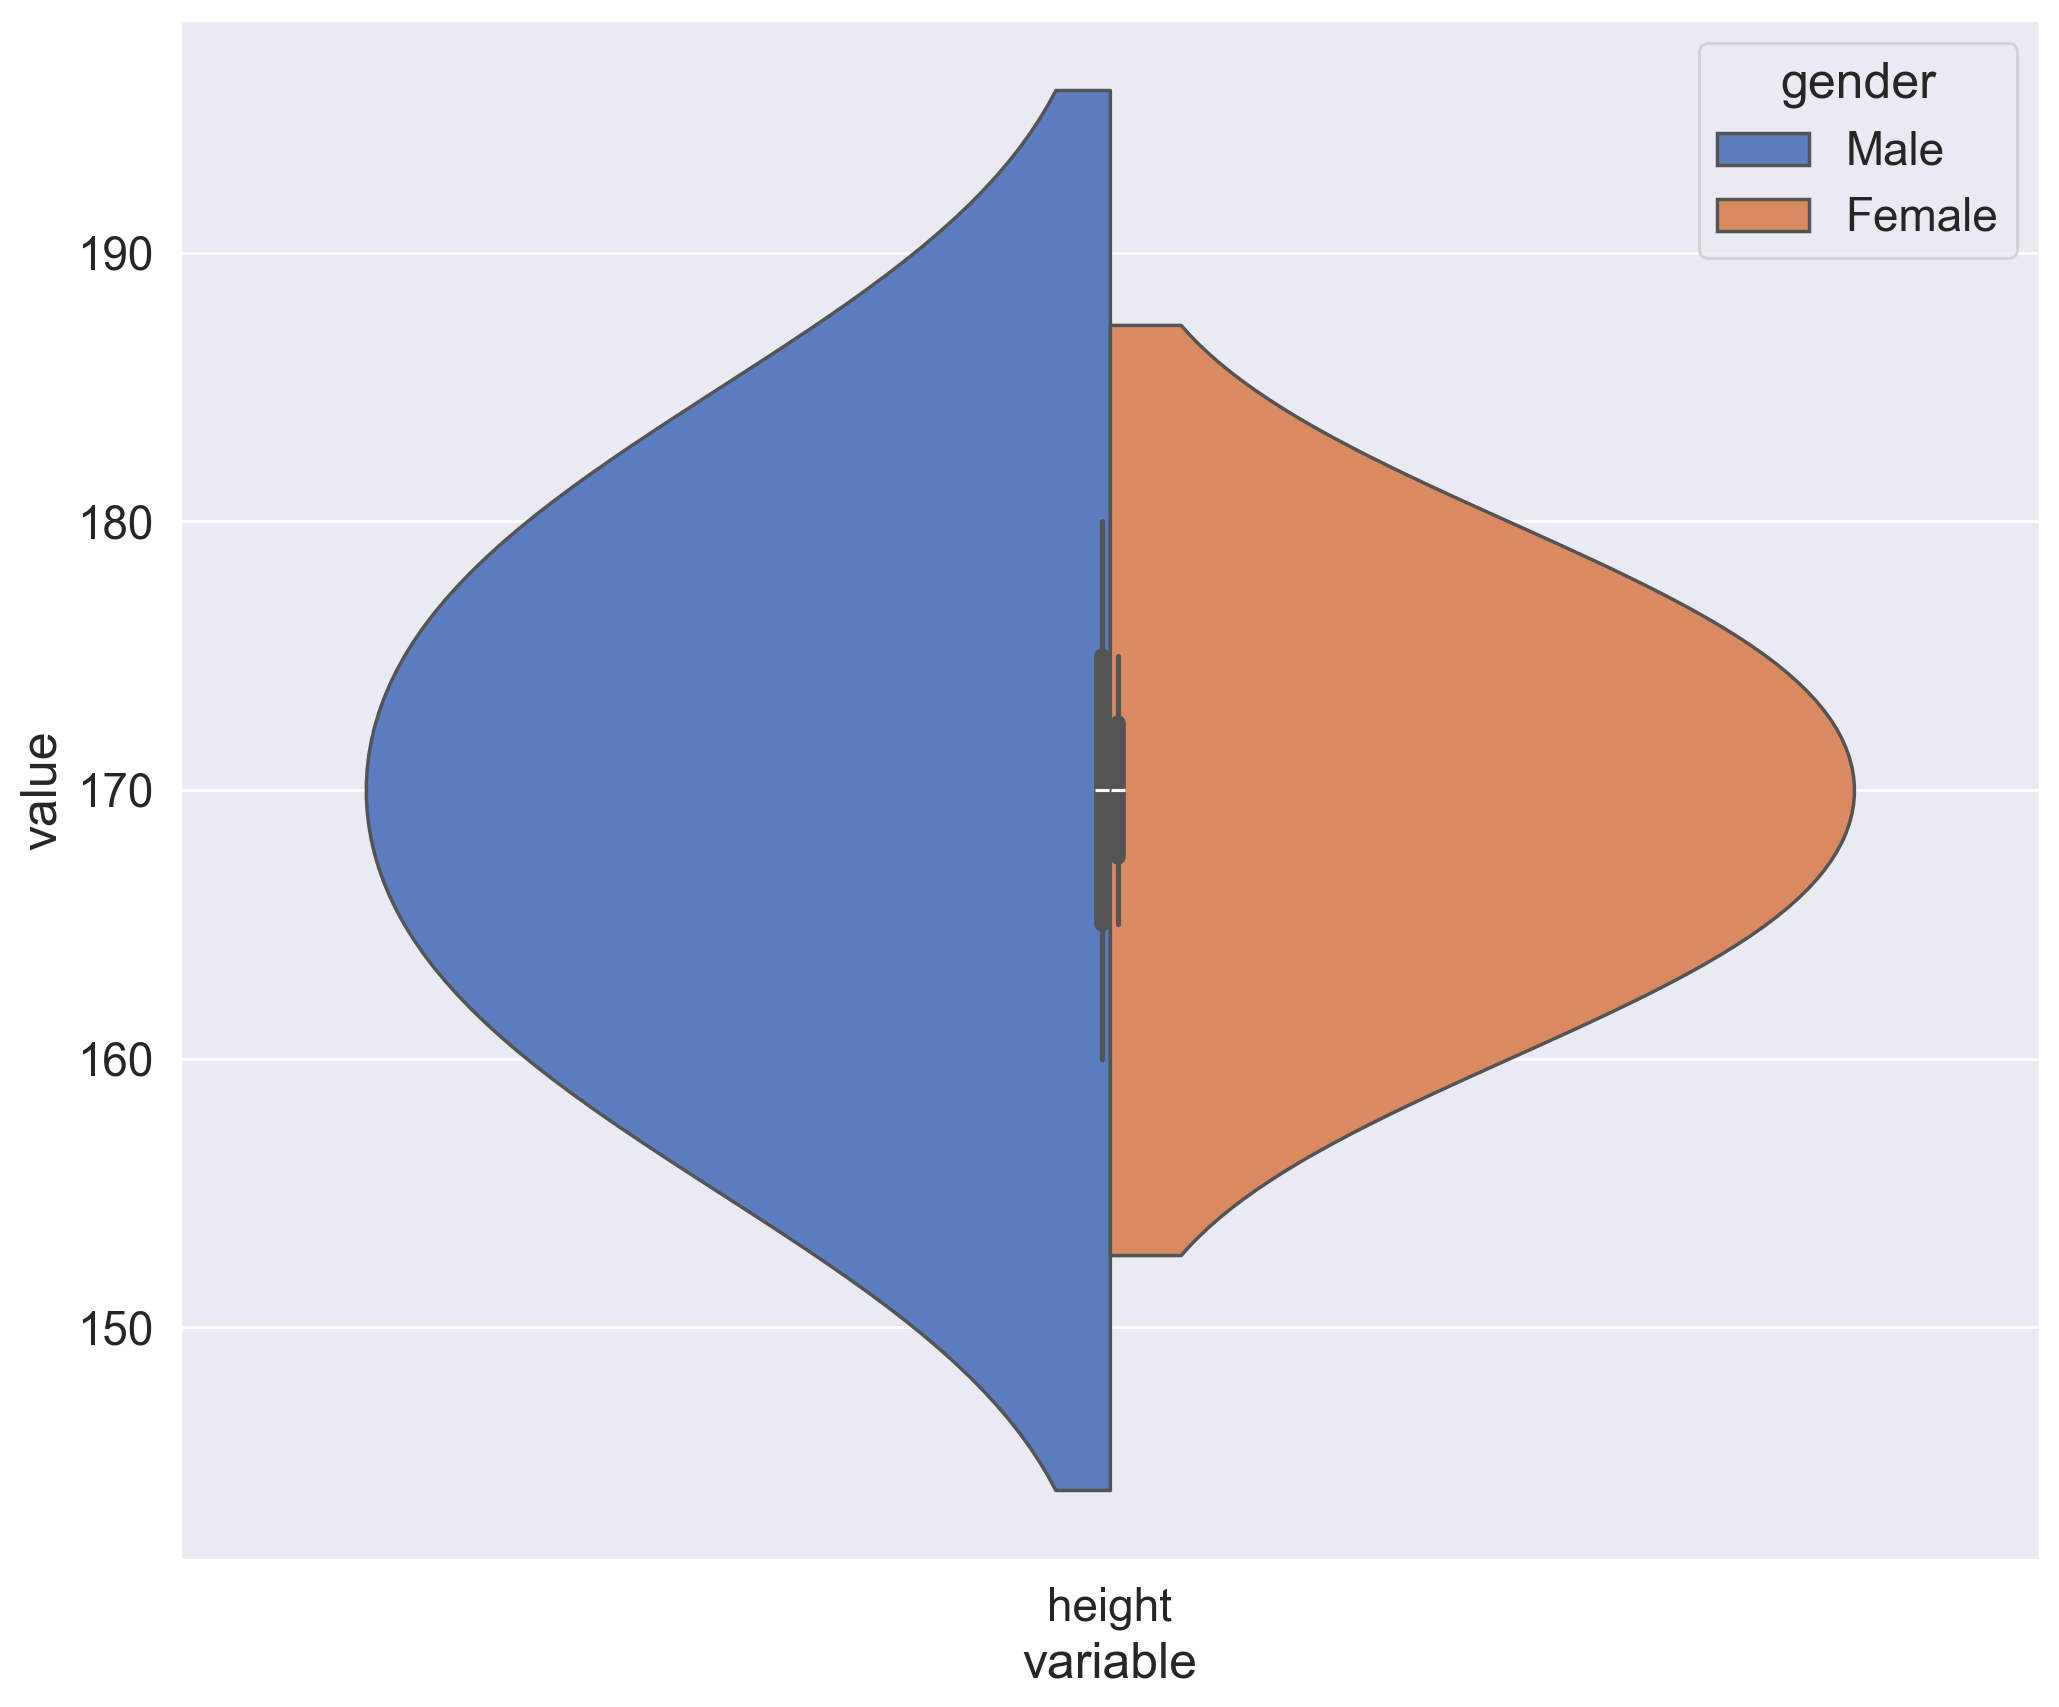

In [26]:
df = pd.DataFrame({
    "age": [50, 40, 60, 30, 45],
    "height": [170, 165, 180, 175, 160],
    "weight": [70, 60, 90, 75, 55],
    "cholesterol": [1, 2, 3, 1, 2],
    "gluc": [1, 2, 2, 1, 3],
    "smoke": [0, 1, 0, 0, 1],
    "alco": [0, 0, 1, 0, 0],
    "active": [1, 0, 1, 1, 0],
    "cardio": [1, 0, 1, 0, 1],
    "gender": ["Male", "Female", "Male", "Female", "Male"]  # Added 'gender' column
})

df_melt = pd.melt(frame=df, value_vars=["height"], id_vars=["gender"])

plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    x="variable",
    y="value",
    hue="gender",
    palette="muted",
    split=True,
    data=df_melt,
    scale="count",
    scale_hue=False,
)

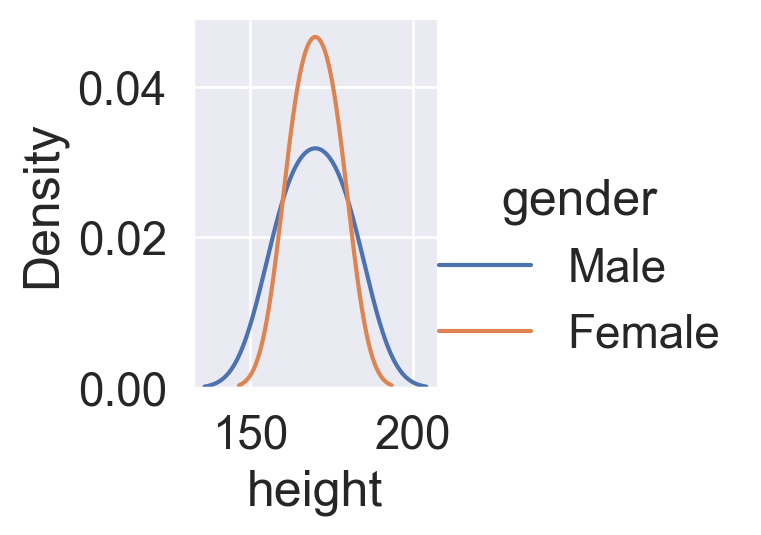

In [27]:
sns.FacetGrid(df, hue="gender").map(sns.kdeplot, "height").add_legend();